In [1]:
# Importing few libraries
import os
import shutil
import random
from tqdm import tqdm

import numpy as np
import pandas as pd

import PIL
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
LABELS = ['SeaLake', 'Highway', 'River', 'Pasture', 'Industrial', 'Residential', 'PermanentCrop', 'AnnualCrop', 'Forest', 'HerbaceousVegetation']
print(LABELS)

class_indices = {'AnnualCrop': 0, 'Forest': 1, 'HerbaceousVegetation': 2, 'Highway': 3, 'Industrial': 4, 'Pasture': 5, 'PermanentCrop': 6, 'Residential': 7, 'River': 8, 'SeaLake': 9}
class_indices

['SeaLake', 'Highway', 'River', 'Pasture', 'Industrial', 'Residential', 'PermanentCrop', 'AnnualCrop', 'Forest', 'HerbaceousVegetation']


{'AnnualCrop': 0,
 'Forest': 1,
 'HerbaceousVegetation': 2,
 'Highway': 3,
 'Industrial': 4,
 'Pasture': 5,
 'PermanentCrop': 6,
 'Residential': 7,
 'River': 8,
 'SeaLake': 9}

In [3]:
from __future__ import division

import re
from sklearn import ensemble
from sklearn.metrics import accuracy_score

from sklearn.model_selection import StratifiedShuffleSplit
from keras.preprocessing.image import ImageDataGenerator

from collections import Counter
import random
import numpy as np
from scipy.stats import mode

Using TensorFlow backend.


In [4]:
import tensorflow as tf
from keras.models import Model
from keras.layers import Dense, Dropout, Flatten
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from keras.optimizers import Adam


from keras.applications import VGG16, VGG19
from keras.applications import ResNet50, ResNet50V2, ResNet152V2
from keras.applications import InceptionV3, Xception

from sklearn.metrics import precision_recall_fscore_support, confusion_matrix, fbeta_score, accuracy_score

In [5]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
  # Restrict TensorFlow to only use the first GPU
  try:
    tf.config.experimental.set_visible_devices(gpus[0], 'GPU')
    logical_gpus = tf.config.experimental.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPU")    
  except RuntimeError as e:
    # Visible devices must be set before GPUs have been initialized
    print(e)
    
tf.config.set_soft_device_placement(True)

1 Physical GPUs, 1 Logical GPU


In [6]:
# Note that for different CNN models we are using different setup of dense layers
def compile_model(cnn_base, input_shape, n_classes, optimizer, fine_tune=None):
    
    if (cnn_base == 'ResNet50') or (cnn_base == 'ResNet50V2') or (cnn_base == 'ResNet152V2'):
        if cnn_base == 'ResNet50':
            conv_base = ResNet50(include_top=False,
                                 weights='imagenet', 
                                 input_shape=input_shape)
        elif cnn_base == 'ResNet50V2':
            conv_base = ResNet50V2(include_top=False,
                                 weights='imagenet', 
                                 input_shape=input_shape)
        else:
            conv_base = ResNet152V2(include_top=False,
                                 weights='imagenet', 
                                 input_shape=input_shape)
        top_model = conv_base.output
        top_model = Flatten()(top_model)
        top_model = Dense(2048, activation='relu')(top_model)
        top_model = Dropout(0.2)(top_model)
       
    
    elif (cnn_base == 'VGG16') or (cnn_base == 'VGG19'):
        if cnn_base == 'VGG16':
            conv_base = VGG16(include_top=False,
                              weights='imagenet', 
                              input_shape=input_shape)
        else:
            conv_base = VGG19(include_top=False,
                              weights='imagenet', 
                              input_shape=input_shape)
        top_model = conv_base.output
        top_model = Flatten()(top_model)
        top_model = Dense(2048, activation='relu')(top_model)
        top_model = Dropout(0.2)(top_model)
        top_model = Dense(2048, activation='relu')(top_model)
        top_model = Dropout(0.2)(top_model)
    
    
    output_layer = Dense(n_classes, activation='softmax')(top_model)
    
    model = Model(inputs=conv_base.input, outputs=output_layer)
        
    if type(fine_tune) == int:
        for layer in conv_base.layers[fine_tune:]:
            layer.trainable = True
    else:
        for layer in conv_base.layers:
            layer.trainable = False

    model.compile(optimizer=optimizer, loss='categorical_crossentropy',
                 metrics=['categorical_accuracy'])
    
    return model

def plot_history(history):
       
    acc = history.history['categorical_accuracy']
    val_acc = history.history['val_categorical_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.plot(acc)
    plt.plot(val_acc)
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')
    
    plt.subplot(1, 2, 2)
    plt.plot(loss)
    plt.plot(val_loss)
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')
    
    plt.show();

def display_results(y_true, y_preds, class_labels):
    
    results = pd.DataFrame(precision_recall_fscore_support(y_true, y_preds),
                          columns=class_labels).T
    results.rename(columns={0: 'Precision',
                           1: 'Recall',
                           2: 'F-Score',
                           3: 'Support'}, inplace=True)
    
    conf_mat = pd.DataFrame(confusion_matrix(y_true, y_preds), 
                            columns=class_labels,
                            index=class_labels)    
    f2 = fbeta_score(y_true, y_preds, beta=2, average='micro')
    accuracy = accuracy_score(y_true, y_preds)
    print(f"Accuracy: {accuracy}")
    print(f"Global F2 Score: {f2}")    
    return results, conf_mat

def plot_predictions(y_true, y_preds, test_generator, class_indices):

    fig = plt.figure(figsize=(20, 10))
    for i, idx in enumerate(np.random.choice(test_generator.samples, size=20, replace=False)):
        ax = fig.add_subplot(4, 5, i + 1, xticks=[], yticks=[])
        ax.imshow(np.squeeze(test_generator[idx]))
        pred_idx = np.argmax(y_preds[idx])
        true_idx = y_true[idx]
                
        plt.tight_layout()
        ax.set_title("{}\n({})".format(class_indices[pred_idx], class_indices[true_idx]),
                     color=("green" if pred_idx == true_idx else "red"))    

In [7]:
NUM_CLASSES = len(LABELS)
INPUT_SHAPE = (64, 64, 3)

vgg16_model = compile_model('VGG16', INPUT_SHAPE, NUM_CLASSES, Adam(lr=1e-2), fine_tune=None)
vgg16_model.load_weights('../input/land-cover-models-weights/vgg16_eurosat.h5')
type(vgg16_model)

58892288/58889256 [==============================] - 0s 0us/step


keras.engine.training.Model

# Data

In [8]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import os
import rasterio
import glob
from tqdm import tqdm

from matplotlib import pyplot as plt
from pylab import rcParams

from PIL import Image

rcParams['figure.figsize'] = 10, 10

ffe8c
../input/radiant-ref-agrifieldnet-competition-v1/content/ref_agrifieldnet_competition_v1/ref_agrifieldnet_competition_v1_source/ref_agrifieldnet_competition_v1_source_ffe8c
(256, 256, 3) 23 88
fake/SeaLake


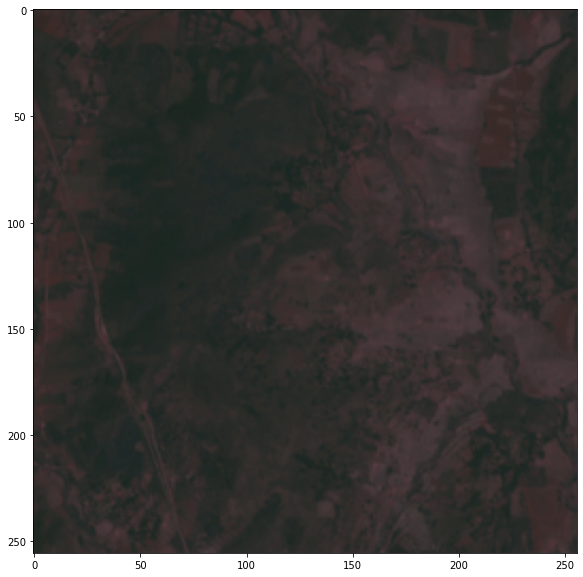

In [9]:
#folder_id = "0b194"

root_input_dir = "../input/radiant-ref-agrifieldnet-competition-v1/content/ref_agrifieldnet_competition_v1"
image_dir_pattern = root_input_dir + "/" + \
    "ref_agrifieldnet_competition_v1_source/" + \
    "ref_agrifieldnet_competition_v1_source_fffff"

image_channels = ["B04", "B02", "B03"] # blue (B2), green (B3), red (B4),
def get_image_from_folder_id(folder_id, dataset="train", max_value=150, debug=False):
    image_dir_file = image_dir_pattern.replace("fffff", folder_id)
    
    if debug:
        print(image_dir_file)
        
    img = []
    for c in image_channels:
        image_filename = f"{image_dir_file}/{c}.tif"
        with rasterio.open(image_filename) as src:
            field_data = src.read()[0]
            img.append(field_data)
            
    im = np.stack(img, axis=0)
    im = np.transpose(im, axes=(1, 2, 0)) # image shape as (H, W, D)

    #im = (((im-im.min())/(im.max()-im.min())*255)).astype(np.uint8)
    
    im = ((im/max_value)*255).astype(np.uint8)
    return im

folder_id = "ffe8c"
print(folder_id)
img = get_image_from_folder_id(folder_id, debug=True)
len(img), img[0].shape

print(img.shape, img.min(), img.max())

im = Image.fromarray(img)
im.save("test.png")

im = Image.fromarray(img[:64, :64, :])
fake_dir = "fake/" + LABELS[0]
print(fake_dir)
!mkdir -p $fake_dir
im.save(f"{fake_dir}/test.png")

rcParams['figure.figsize'] = 10, 10
plt.imshow(img);
#plt.imshow(img)

In [10]:
test_gen = ImageDataGenerator(
    rescale=1./255,
)

TEST_DIR = "fake"

test_generator_new = test_gen.flow_from_directory(
    directory=TEST_DIR,
    target_size=(64, 64),
    batch_size=1,
    class_mode=None,
    color_mode='rgb',
    shuffle=False,
    seed=69
)

predictions = vgg16_model.predict_generator(test_generator_new, steps=len(test_generator_new.filenames))
predictions

Found 1 images belonging to 1 classes.


array([[1.3807971e-02, 3.9443228e-02, 9.1315851e-02, 1.0565480e-03,
        2.7050063e-04, 8.3990175e-01, 7.8226104e-03, 5.7868683e-04,
        3.8561693e-03, 1.9466417e-03]], dtype=float32)

In [11]:
predictions.sum()

class_indices

{'AnnualCrop': 0,
 'Forest': 1,
 'HerbaceousVegetation': 2,
 'Highway': 3,
 'Industrial': 4,
 'Pasture': 5,
 'PermanentCrop': 6,
 'Residential': 7,
 'River': 8,
 'SeaLake': 9}

In [12]:
!ls ../input/radiant-fields2images/images/train | wc
!ls ../input/radiant-fields2images/images/test | wc

ls: cannot access '../input/radiant-fields2images/images/train': No such file or directory
      0       0       0
ls: cannot access '../input/radiant-fields2images/images/test': No such file or directory
      0       0       0


In [13]:
test_generator_new = test_gen.flow_from_directory(
    #directory="../input/radiant-fields2images/images",
    directory="../input/radiant-neighbour2images/images",
    target_size=(64, 64),
    batch_size=1,
    class_mode=None,
    color_mode='rgb',
    shuffle=False,
    seed=69
)

predictions = vgg16_model.predict_generator(test_generator_new, steps=len(test_generator_new.filenames))
predictions

Found 37130 images belonging to 2 classes.


array([[2.4682612e-03, 9.6405214e-01, 1.9230337e-03, ..., 3.0393082e-06,
        1.5132224e-04, 1.2001609e-02],
       [3.2855389e-01, 7.5727612e-02, 5.2312400e-02, ..., 1.1571644e-04,
        2.8955547e-02, 8.2956851e-02],
       [3.2855389e-01, 7.5727612e-02, 5.2312400e-02, ..., 1.1571644e-04,
        2.8955547e-02, 8.2956851e-02],
       ...,
       [3.8199614e-05, 1.3284199e-04, 9.9418193e-01, ..., 1.8834426e-05,
        6.5433469e-06, 6.3301549e-08],
       [2.1682395e-06, 1.2150942e-06, 9.9810636e-01, ..., 5.6092790e-07,
        1.0463978e-07, 1.0607239e-10],
       [6.5211162e-07, 2.0474896e-07, 9.9931026e-01, ..., 7.3929073e-08,
        1.0788333e-08, 8.8531630e-12]], dtype=float32)

In [14]:
# test == 0, train == 1, test first, train later
filenames = test_generator_new.filenames[:]

print(len(filenames), filenames[:3], filenames[-3:])

true_classes = test_generator_new.classes[:]
true_classes[:3], true_classes[-3], len(true_classes), true_classes.sum()

37130 ['test/001c1_6533_east.png', 'test/001c1_6533_main.png', 'test/001c1_6533_north.png'] ['train/ffe8c_4617_north.png', 'train/ffe8c_4617_south.png', 'train/ffe8c_4617_west.png']


(array([0, 0, 0], dtype=int32), 1, 37130, 29100)

In [15]:
!rm -rf fake
!rm -rf test.png
!ls -alh

total 24K
drwxr-xr-x 2 root root 4.0K Oct 10 18:31 .
drwxr-xr-x 6 root root 4.0K Oct 10 18:27 ..
---------- 1 root root  13K Oct 10 18:27 __notebook__.ipynb


In [16]:
dict_predictions = {
    "filenames": filenames,
    "predictions": predictions
}


import pickle

with open('dict_predictions.pickle', 'wb') as handle:
    pickle.dump(dict_predictions, handle, protocol=3)
    
!ls -alh

total 2.7M
drwxr-xr-x 2 root root 4.0K Oct 10 18:31 .
drwxr-xr-x 6 root root 4.0K Oct 10 18:27 ..
---------- 1 root root  13K Oct 10 18:27 __notebook__.ipynb
-rw-r--r-- 1 root root 2.7M Oct 10 18:31 dict_predictions.pickle


In [17]:
predicted_classes = np.argmax(np.rint(predictions), axis=1)
predicted_classes[:3]

unique, counts = np.unique(predicted_classes, return_counts=True)
print(np.asarray((unique, counts)).T)

class_indices

[[    0  3386]
 [    1  7148]
 [    2 22516]
 [    3    74]
 [    4   127]
 [    5  2792]
 [    6   644]
 [    7   379]
 [    8    11]
 [    9    53]]


{'AnnualCrop': 0,
 'Forest': 1,
 'HerbaceousVegetation': 2,
 'Highway': 3,
 'Industrial': 4,
 'Pasture': 5,
 'PermanentCrop': 6,
 'Residential': 7,
 'River': 8,
 'SeaLake': 9}

In [18]:
class_indices

{'AnnualCrop': 0,
 'Forest': 1,
 'HerbaceousVegetation': 2,
 'Highway': 3,
 'Industrial': 4,
 'Pasture': 5,
 'PermanentCrop': 6,
 'Residential': 7,
 'River': 8,
 'SeaLake': 9}